In [1]:
from hfpred.utils import get_project_root
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from scipy.stats import ttest_ind

from IPython.display import display
import dataframe_image as dfi
pd.set_option("display.max_columns", None)

# Candidate Models
* investigate candidate models using default hyperparameters
* train on training set only 
* need to predict clusters for validation set - as would be in test/prediction pipeline
* use validation set to assess performance
* assess whether cluster labels as an engineered feature significantly changes performance

In [2]:
df = pd.read_csv(
    get_project_root() / "data/heart-processed.csv",
    index_col=0
)
print(f"dataset instances: {len(df)}")
df.tail()

dataset instances: 671


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,RestingECG_Normal,ExerciseAngina_N,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease,train/val
209,0.530612,0.305556,0.252896,0.0,0.533835,0.015873,1,1,0,0,1,1,0,1,0,1,val
704,0.448980,0.537037,0.305019,0.0,0.443609,0.428571,1,1,0,0,0,1,0,1,0,1,val
665,0.285714,0.407407,0.444015,0.0,0.421053,0.301587,1,1,0,0,1,0,0,1,0,1,val
447,1.000000,0.296296,0.166023,0.0,0.308271,0.333333,1,1,0,0,0,0,0,0,1,1,val
907,0.326531,0.259259,0.162162,0.0,0.563910,0.460317,1,1,0,0,1,0,1,0,0,1,val


In [3]:
# retrieve training/validation data:
train = df[df["train/val"] == "train"]
val = df[df["train/val"] == "val"]

# split attributes and target:
cols = list(df.columns)
cols.pop(cols.index("HeartDisease"))

x_train = train[cols].copy()
y_train = train["HeartDisease"].copy()

x_val = val[cols].copy()
y_val = val["HeartDisease"].copy()

# remove train/val tags:
x_train.drop(columns="train/val", inplace=True)
x_val.drop(columns="train/val", inplace=True)

In [4]:
y_train.value_counts()/len(y_train)

0    0.51306
1    0.48694
Name: HeartDisease, dtype: float64

In [5]:
y_val.value_counts()/len(y_val)

0    0.555556
1    0.444444
Name: HeartDisease, dtype: float64

## Clustering Algorithm (Feature Engineering)

### k-Means Cluster Labels
* as the categorical data has been one-hot-encoded and the continuous data has been scaled can use k-means to cluster
* cannot have the target label affect the clustering - as this will not be available in future predictions

Text(0.5, 1.0, 'Elbow curve')

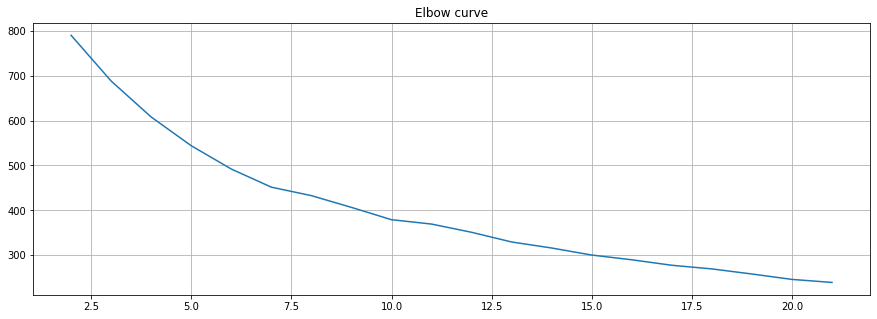

In [6]:
SSEs = []
for k in range(2,22):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x_train)
    SSEs.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 22), SSEs)
plt.grid(True)
plt.title('Elbow curve')


In [7]:
kmeans = KMeans(
    n_clusters=7,
    random_state=13
).fit(x_train)

In [8]:
# assign cluster label to training:
x_train["cluster_label"] = kmeans.labels_

In [9]:
# predict cluster label for validation set:
x_val["cluster_label"] = kmeans.predict(x_val)

## Supervised Models
#### Investigate the candidate models with and without cluster labels as input:

In [10]:
# create a copy of the data without cluster labels:
x_train_no_clust = x_train.drop(columns="cluster_label")
x_val_no_cluster = x_val.drop(columns="cluster_label")

### Metrics

In [11]:
# define func for returning metrics:
def met_score(
    model,
    name,
    pre_cluster=False,
    x=x_train_no_clust,
    y=y_train,
    vx=x_val_no_cluster,
    vy=y_val
    ):

    if pre_cluster:
        x=x_train
        vx=x_val

    scores = pd.DataFrame()
    for set in [("train", x, y), ("val", vx, vy)]:
        for metric in [
            ("accuracy", accuracy_score),
            ("recall", recall_score),
            ("precision", precision_score),
            ("f1", f1_score),
            ("ROC_AUC", roc_auc_score)
        ]:
            scores[f"{set[0]}_{metric[0]}"] = [metric[1](set[2], model.predict(set[1]))]

    scores.rename(index={0:f"{name}"}, inplace=True)

    return scores

---
### k-Neighbours Classifier [No Clustering]

In [12]:
knn_clf_no_clust = KNeighborsClassifier()
knn_clf_no_clust.fit(x_train_no_clust, y_train)
knn = met_score(knn_clf_no_clust, "kNN [No Clustering]")
knn

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
kNN [No Clustering],0.852612,0.862069,0.839552,0.850662,0.852853,0.925926,0.966667,0.878788,0.920635,0.93


### k-Neighbours Classifier [pre-Clustering]

In [13]:
knn_clf_pre_clust = KNeighborsClassifier()
knn_clf_pre_clust.fit(x_train, y_train)
knn_c = met_score(knn_clf_pre_clust, "kNN [pre-Clustering]", pre_cluster=True)
knn_c

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
kNN [pre-Clustering],0.848881,0.869732,0.828467,0.848598,0.849411,0.925926,0.966667,0.878788,0.920635,0.93


---
### SVM [No Clustering]

In [14]:
svc_clf_no_clust = SVC()
svc_clf_no_clust.fit(x_train_no_clust, y_train)
svc = met_score(svc_clf_no_clust, "SVM Classifier [No Clustering]")
svc

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
SVM Classifier [No Clustering],0.875,0.896552,0.854015,0.874766,0.875549,0.911111,0.933333,0.875,0.903226,0.913333


### SVM [with pre-Clustering]

In [15]:
svc_clf_pre_clust = SVC()
svc_clf_pre_clust.fit(x_train, y_train)
svc_c = met_score(svc_clf_pre_clust, "SVM Classifier [pre-Clustering]", pre_cluster=True)
svc_c

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
SVM Classifier [pre-Clustering],0.856343,0.89272,0.826241,0.858195,0.857269,0.911111,0.95,0.863636,0.904762,0.915


---
### Random Forest Classifier [No Clustering]

In [16]:
rf_clf_no_clust = RandomForestClassifier()
rf_clf_no_clust.fit(x_train_no_clust, y_train)
rf = met_score(rf_clf_no_clust, "Random Forest [No Clustering]")
rf

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Random Forest [No Clustering],1.0,1.0,1.0,1.0,1.0,0.896296,0.9,0.870968,0.885246,0.896667


### Random Forest Classifier [with pre-Clustering]

In [17]:
rf_clf_pre_clust = RandomForestClassifier()
rf_clf_pre_clust.fit(x_train, y_train)
rf_c = met_score(rf_clf_pre_clust, "Random Forest [pre-Clustering]", pre_cluster=True)
rf_c

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Random Forest [pre-Clustering],1.0,1.0,1.0,1.0,1.0,0.918519,0.933333,0.888889,0.910569,0.92


---
### Logistic Regression [No Clustering]

In [18]:
lr_clf_no_clust = LogisticRegression()
lr_clf_no_clust.fit(x_train_no_clust, y_train)
lr = met_score(lr_clf_no_clust, "Logistic Regression [No Clustering]")
lr

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Logistic Regression [No Clustering],0.854478,0.869732,0.837638,0.853383,0.854866,0.911111,0.933333,0.875,0.903226,0.913333


### Logistic Regression [with pre-Clustering]

In [19]:
lr_clf_pre_clust = LogisticRegression()
lr_clf_pre_clust.fit(x_train, y_train)
lr_c = met_score(lr_clf_pre_clust, "Logistic Regression [pre-Clustering]", pre_cluster=True)
lr_c

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Logistic Regression [pre-Clustering],0.854478,0.881226,0.830325,0.855019,0.855158,0.896296,0.95,0.838235,0.890625,0.901667


---
### XGBoost [No Clustering]

In [20]:
xgb_clf_no_clust = XGBClassifier()
xgb_clf_no_clust.fit(x_train_no_clust, y_train)
xgb = met_score(xgb_clf_no_clust, "XGBoost [No Clustering]")
xgb

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
XGBoost [No Clustering],1.0,1.0,1.0,1.0,1.0,0.888889,0.9,0.857143,0.878049,0.89


### XGBoost [with pre-Clustering]

In [21]:
xgb_clf_pre_clust = XGBClassifier()
xgb_clf_pre_clust.fit(x_train, y_train)
xgb_c = met_score(xgb_clf_pre_clust, "XGBoost [pre-Clustering]", pre_cluster=True)
xgb_c

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
XGBoost [pre-Clustering],1.0,1.0,1.0,1.0,1.0,0.896296,0.9,0.870968,0.885246,0.896667


---

## Model Round-Up [Single Run]

In [22]:
model_scoring = pd.concat(
    [
        knn,
        knn_c,
        svc,
        svc_c,
        rf,
        rf_c,
        lr,
        lr_c,
        xgb,
        xgb_c
    ]
)
model_scoring

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
kNN [No Clustering],0.852612,0.862069,0.839552,0.850662,0.852853,0.925926,0.966667,0.878788,0.920635,0.930000
kNN [pre-Clustering],0.848881,0.869732,0.828467,0.848598,0.849411,0.925926,0.966667,0.878788,0.920635,0.930000
SVM Classifier [No Clustering],0.875000,0.896552,0.854015,0.874766,0.875549,0.911111,0.933333,0.875000,0.903226,0.913333
SVM Classifier [pre-Clustering],0.856343,0.892720,0.826241,0.858195,0.857269,0.911111,0.950000,0.863636,0.904762,0.915000
Random Forest [No Clustering],1.000000,1.000000,1.000000,1.000000,1.000000,0.896296,0.900000,0.870968,0.885246,0.896667
Random Forest [pre-Clustering],1.000000,1.000000,1.000000,1.000000,1.000000,0.918519,0.933333,0.888889,0.910569,0.920000
Logistic Regression [No Clustering],0.854478,0.869732,0.837638,0.853383,0.854866,0.911111,0.933333,0.875000,0.903226,0.913333
Logistic Regression [pre-Clustering],0.854478,0.881226,0.830325,0.855019,0.855158,0.896296,0.950000,0.838235,0.890625,0.901667
XGBoost [No Clustering],1.000000,1.000000,1.000000,1.000000,1.000000,0.888889,0.900000,0.857143,0.878049,0.890000
XGBoost [pre-Clustering],1.000000,1.000000,1.000000,1.000000,1.000000,0.896296,0.900000,0.870968,0.885246,0.896667


In [ ]:
# dfi.export(
#     model_scoring,
#     "../output/tables/model_roundup.png"
# )

---
## Candidate Models [Averaged Scores]
* as there is some randomness to some of the algorithms, the average output will be taken from 100 runs for each model
* the average and standard deviation for each model will be recorded with and without cluster labels included in the input in order to perform a paired t-test to assess whether the inclusion of cluster labels significantly changes performance
* set random seeds for model iterations involving some randomness -- but not random state (this would run same state repeatedly)

In [24]:
# define func for returning metrics:
def met_score(
    model,
    # name,
    pre_cluster=False,
    x=x_train_no_clust,
    y=y_train,
    vx=x_val_no_cluster,
    vy=y_val
    ):

    if pre_cluster:
        x=x_train
        vx=x_val

    scores = pd.DataFrame()
    for set in [("train", x, y), ("val", vx, vy)]:
        for metric in [
            ("accuracy", accuracy_score),
            ("recall", recall_score),
            ("precision", precision_score),
            ("f1", f1_score),
            ("ROC_AUC", roc_auc_score)
        ]:
            scores[f"{set[0]}_{metric[0]}"] = [metric[1](set[2], model.predict(set[1]))]

    return scores

In [25]:
# average over given number of runs:
def model_average(
    model,
    name,
    runs = 100,
    pre_cluster=False,
    x=x_train_no_clust,
    y=y_train,
    vx=x_val_no_cluster,
    vy=y_val
    ):

    if pre_cluster:
        x=x_train
        vx=x_val

    model_scores = pd.DataFrame()

    for i in range(runs):
        model.fit(x,y)
        run_score = met_score(model, pre_cluster)
        model_scores = pd.concat([model_scores, run_score])
    
    model_mean = model_scores.mean().to_frame().transpose()
    model_mean.rename(index={0:f"{name}"}, inplace=True)
    model_std = model_scores.std().to_frame().transpose()
    model_std.rename(index={0:f"{name}"}, inplace=True)
    # model_summary = pd.concat([model_mean, model_std])

    return model_scores, model_mean, model_std

---
### k-Neighbours Classifier

In [26]:
_, knn_av, knn_std = model_average(
    KNeighborsClassifier(),
    "kNN [No Clustering]",
    runs=100
)

In [27]:
knn_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
kNN [No Clustering],0.852612,0.862069,0.839552,0.850662,0.852853,0.925926,0.966667,0.878788,0.920635,0.93


In [28]:
knn_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
kNN [No Clustering],5.579081e-16,0.0,3.347448e-16,3.347448e-16,2.231632e-16,2.231632e-16,0.0,2.231632e-16,2.231632e-16,1.115816e-16


In [29]:
_, knn_c_av, knn_c_std = model_average(
    KNeighborsClassifier(),
    "kNN [preClustering]",
    pre_cluster=True,
    runs=100
)

In [30]:
knn_c_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
kNN [preClustering],0.848881,0.869732,0.828467,0.848598,0.849411,0.925926,0.966667,0.878788,0.920635,0.93


In [31]:
knn_c_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
kNN [preClustering],3.347448e-16,1.115816e-16,4.463264e-16,3.347448e-16,1.115816e-16,2.231632e-16,0.0,2.231632e-16,2.231632e-16,1.115816e-16


---
### SVM Classifier

In [32]:
_, svc_av, svc_std = model_average(
    SVC(),
    "SVM Classifier [No Clustering]",
    runs=100
)

In [33]:
svc_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
SVM Classifier [No Clustering],0.875,0.896552,0.854015,0.874766,0.875549,0.911111,0.933333,0.875,0.903226,0.913333


In [34]:
svc_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
SVM Classifier [No Clustering],0.0,1.115816e-16,1.115816e-16,2.231632e-16,2.231632e-16,2.231632e-16,2.231632e-16,0.0,1.115816e-16,2.231632e-16


In [35]:
_, svc_c_av, svc_c_std = model_average(
    SVC(),
    "SVM Classifier [preClustering]",
    pre_cluster=True,
    runs=100
)

In [36]:
svc_c_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
SVM Classifier [preClustering],0.856343,0.89272,0.826241,0.858195,0.857269,0.911111,0.95,0.863636,0.904762,0.915


In [37]:
svc_c_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
SVM Classifier [preClustering],1.115816e-16,3.347448e-16,1.115816e-16,3.347448e-16,2.231632e-16,2.231632e-16,0.0,3.347448e-16,1.115816e-16,0.0


---
### Random Forest Classifier

In [38]:
np.random.seed(13)
_, rf_av, rf_std = model_average(
    RandomForestClassifier(),
    "Random Forest Classifier [No Clustering]",
)

In [39]:
rf_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Random Forest Classifier [No Clustering],1.0,1.0,1.0,1.0,1.0,0.913926,0.93,0.88278,0.9057,0.915533


In [40]:
rf_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Random Forest Classifier [No Clustering],0.0,0.0,0.0,0.0,0.0,0.008275,0.012535,0.011961,0.008995,0.008311


In [41]:
np.random.seed(13)
_, rf_c_av, rf_c_std = model_average(
    RandomForestClassifier(),
    "Random Forest Classifier [preClustering]",
    pre_cluster=True,
)

In [42]:
rf_c_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Random Forest Classifier [preClustering],1.0,1.0,1.0,1.0,1.0,0.914889,0.935833,0.880344,0.907182,0.916983


In [43]:
rf_c_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Random Forest Classifier [preClustering],0.0,0.0,0.0,0.0,0.0,0.007772,0.011695,0.010762,0.008459,0.007834


---
### Logistic Regression

In [44]:
_, lr_av, lr_std = model_average(
    LogisticRegression(),
    "Logistic Regression [No Clustering]",
)

In [45]:
lr_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Logistic Regression [No Clustering],0.854478,0.869732,0.837638,0.853383,0.854866,0.911111,0.933333,0.875,0.903226,0.913333


In [46]:
lr_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Logistic Regression [No Clustering],1.115816e-16,1.115816e-16,2.231632e-16,0.0,2.231632e-16,2.231632e-16,2.231632e-16,0.0,1.115816e-16,2.231632e-16


In [47]:
_, lr_c_av, lr_c_std = model_average(
    LogisticRegression(),
    "Logistic Regression [preClustering]",
    pre_cluster=True,
)

In [48]:
lr_c_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Logistic Regression [preClustering],0.854478,0.881226,0.830325,0.855019,0.855158,0.896296,0.95,0.838235,0.890625,0.901667


In [49]:
lr_c_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Logistic Regression [preClustering],1.115816e-16,1.115816e-16,2.231632e-16,0.0,0.0,1.115816e-16,0.0,0.0,0.0,2.231632e-16


---
### XGBoost

In [50]:
_, xgb_av, xgb_std = model_average(
    XGBClassifier(),
    "XGBoost Classifier [No Clustering]",
)

In [51]:
xgb_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
XGBoost Classifier [No Clustering],1.0,1.0,1.0,1.0,1.0,0.888889,0.9,0.857143,0.878049,0.89


In [52]:
xgb_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
XGBoost Classifier [No Clustering],0.0,0.0,0.0,0.0,0.0,1.115816e-16,4.463264e-16,1.115816e-16,1.115816e-16,1.115816e-16


In [53]:
_, xgb_c_av, xgb_c_std = model_average(
    XGBClassifier(),
    "XGBoost Classifier [preClustering]",
    pre_cluster=True,
)

In [54]:
xgb_c_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
XGBoost Classifier [preClustering],1.0,1.0,1.0,1.0,1.0,0.896296,0.9,0.870968,0.885246,0.896667


In [55]:
xgb_c_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
XGBoost Classifier [preClustering],0.0,0.0,0.0,0.0,0.0,1.115816e-16,4.463264e-16,1.115816e-16,0.0,2.231632e-16


---
## Model Round-Up [100 Run Average]

In [56]:
model_scoring_av = pd.concat(
    [
        knn_av,
        knn_c_av,
        svc_av,
        svc_c_av,
        rf_av,
        rf_c_av,
        lr_av,
        lr_c_av,
        xgb_av,
        xgb_c_av
    ]
)
model_scoring_av

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
kNN [No Clustering],0.852612,0.862069,0.839552,0.850662,0.852853,0.925926,0.966667,0.878788,0.920635,0.930000
kNN [preClustering],0.848881,0.869732,0.828467,0.848598,0.849411,0.925926,0.966667,0.878788,0.920635,0.930000
SVM Classifier [No Clustering],0.875000,0.896552,0.854015,0.874766,0.875549,0.911111,0.933333,0.875000,0.903226,0.913333
SVM Classifier [preClustering],0.856343,0.892720,0.826241,0.858195,0.857269,0.911111,0.950000,0.863636,0.904762,0.915000
Random Forest Classifier [No Clustering],1.000000,1.000000,1.000000,1.000000,1.000000,0.913926,0.930000,0.882780,0.905700,0.915533
Random Forest Classifier [preClustering],1.000000,1.000000,1.000000,1.000000,1.000000,0.914889,0.935833,0.880344,0.907182,0.916983
Logistic Regression [No Clustering],0.854478,0.869732,0.837638,0.853383,0.854866,0.911111,0.933333,0.875000,0.903226,0.913333
Logistic Regression [preClustering],0.854478,0.881226,0.830325,0.855019,0.855158,0.896296,0.950000,0.838235,0.890625,0.901667
XGBoost Classifier [No Clustering],1.000000,1.000000,1.000000,1.000000,1.000000,0.888889,0.900000,0.857143,0.878049,0.890000
XGBoost Classifier [preClustering],1.000000,1.000000,1.000000,1.000000,1.000000,0.896296,0.900000,0.870968,0.885246,0.896667


In [ ]:
# dfi.export(
#     model_scoring_av,
#     "../output/tables/model_av_summ.png"
# )

---
## Do Cluster Labels Significantly Alter Model Performance?
* use paired t-test to assess whether the cluster labels affect model performance
* (remember that the cluster labels in the validation set are predicted labels when k-means is fit to the training set)

In [58]:
model_scoring_std = pd.concat(
    [
        knn_std,
        knn_c_std,
        svc_std,
        svc_c_std,
        rf_std,
        rf_c_std,
        lr_std,
        lr_c_std,
        xgb_std,
        xgb_c_std
    ]
)
model_scoring_std

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
kNN [No Clustering],5.579081e-16,0.000000e+00,3.347448e-16,3.347448e-16,2.231632e-16,2.231632e-16,0.000000e+00,2.231632e-16,2.231632e-16,1.115816e-16
kNN [preClustering],3.347448e-16,1.115816e-16,4.463264e-16,3.347448e-16,1.115816e-16,2.231632e-16,0.000000e+00,2.231632e-16,2.231632e-16,1.115816e-16
SVM Classifier [No Clustering],0.000000e+00,1.115816e-16,1.115816e-16,2.231632e-16,2.231632e-16,2.231632e-16,2.231632e-16,0.000000e+00,1.115816e-16,2.231632e-16
SVM Classifier [preClustering],1.115816e-16,3.347448e-16,1.115816e-16,3.347448e-16,2.231632e-16,2.231632e-16,0.000000e+00,3.347448e-16,1.115816e-16,0.000000e+00
Random Forest Classifier [No Clustering],0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.275373e-03,1.253502e-02,1.196091e-02,8.995237e-03,8.311014e-03
Random Forest Classifier [preClustering],0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.772164e-03,1.169549e-02,1.076196e-02,8.459108e-03,7.834193e-03
Logistic Regression [No Clustering],1.115816e-16,1.115816e-16,2.231632e-16,0.000000e+00,2.231632e-16,2.231632e-16,2.231632e-16,0.000000e+00,1.115816e-16,2.231632e-16
Logistic Regression [preClustering],1.115816e-16,1.115816e-16,2.231632e-16,0.000000e+00,0.000000e+00,1.115816e-16,0.000000e+00,0.000000e+00,0.000000e+00,2.231632e-16
XGBoost Classifier [No Clustering],0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.115816e-16,4.463264e-16,1.115816e-16,1.115816e-16,1.115816e-16
XGBoost Classifier [preClustering],0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.115816e-16,4.463264e-16,1.115816e-16,0.000000e+00,2.231632e-16


* on reflection, there is only an element of randomness for the Random Forest algorithm (as observed in the SD of the other 4 algorithms). This means that an independent two-sample t-test can be used to test if the pre-clustering significantly altered the performance of the Random Forest supervised learning algorithm.
* a further avenue to explore would to be use some k-fold cross validation to record an average and standard deviation for all of the algorithms -- as the training / validation set is different for each fold

### Welch's unequal variances *t*-test
* [Independent_two-sample_t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test)
* [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test)
$$t=\frac{\Delta\bar{X}}{s_{\Delta\bar{X}}}=\frac{\bar{X_1}-\bar{X_2}}{\sqrt{s^{2}_{\bar{X_1}}+s^{2}_{\bar{X_2}}}}$$
$$s_{\bar{X_i}}=\frac{s_i}{\sqrt{N_i}}$$
, where $\bar{X_i}$ and $s_{\bar{X_i}}$ are the sample mean and its standard error for a given sample standard deviation $s_i$ and sample size $N_i$, so:
$$t=\frac{\bar{X_1}-\bar{X_2}}{s_{\bar{\Delta}}}$$
, where:
$$s_{\bar{\Delta}}=\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}$$

In [59]:
np.random.seed(13)
rf_sample, rf_av, rf_std = model_average(
    RandomForestClassifier(),
    "Random Forest Classifier [No Clustering]",
)

In [60]:
np.random.seed(13)
rf_sample_c, rf_c_av, rf_c_std = model_average(
    RandomForestClassifier(),
    "Random Forest Classifier [preClustering]",
    pre_cluster=True,
)

In [61]:
rf_100 = pd.concat([rf_av, rf_c_av])
rf_100

,train_accuracy,train_recall,train_precision,train_f1,train_ROC_AUC,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
Random Forest Classifier [No Clustering],1.0,1.0,1.0,1.0,1.0,0.913926,0.930000,0.882780,0.905700,0.915533
Random Forest Classifier [preClustering],1.0,1.0,1.0,1.0,1.0,0.914889,0.935833,0.880344,0.907182,0.916983


In [ ]:
# dfi.export(
#     rf_100,
#     "../output/tables/rf_100.png"
# )

In [63]:
# independent t-test
ttest_ind(
    rf_sample["val_ROC_AUC"],
    rf_sample_c["val_ROC_AUC"],
    equal_var=False
)

Ttest_indResult(statistic=-1.2695507625797977, pvalue=0.2057400115107185)

* there is no significant change in performance when measuring ROC-AUC at 5\% significance

In [64]:
metrics = [
    "val_accuracy",
    "val_recall",
    "val_precision",
    "val_f1",
    "val_ROC_AUC"
]

ttest = pd.DataFrame(
    columns=[
        metrics
    ],
    index=[
        "t-statistic",
        "p-value"
    ]
)

for metric in metrics:
    t,p = ttest_ind(
        rf_sample[metric],
        rf_sample_c[metric],
        equal_var=False
    )
    ttest.at["t-statistic", metric] = t
    ttest.at["p-value", metric] = p

ttest


,val_accuracy,val_recall,val_precision,val_f1,val_ROC_AUC
t-statistic,-0.848209,-3.402582,1.514097,-1.200307,-1.269551
p-value,0.39735,0.000808,0.131614,0.23146,0.20574


In [ ]:
# dfi.export(
#     ttest,
#     "../output/tables/rf_ttest.png"
# )

* the only significant increase is where the performance of the random forest is measured by 'recall'.

* could try different clustering algorithms
* could have performed hyperameter tuning to the supervised models at this point